# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

# segue lista adicional de imports necessários para resolução das questões
from sklearn.preprocessing import (KBinsDiscretizer, StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

In [5]:
#inspecionando os tipos para validar as observações

countries.dtypes

Country              object
Region               object
Population            int64
Area                  int64
Pop_density          object
Coastline_ratio      object
Net_migration        object
Infant_mortality     object
GDP                 float64
Literacy             object
Phones_per_1000      object
Arable               object
Crops                object
Other                object
Climate              object
Birthrate            object
Deathrate            object
Agriculture          object
Industry             object
Service              object
dtype: object

In [6]:
# conversão das strings numericas em floats
def str_to_float(str):
    try:
        return float(str.replace(',','.'))
    except:
        return str

countries = countries.applymap(str_to_float)

# funciona?
countries.dtypes

Country              object
Region               object
Population            int64
Area                  int64
Pop_density         float64
Coastline_ratio     float64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones_per_1000     float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
dtype: object

In [7]:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [8]:
# removendo os espaços nas colunas de texto

countries['Region'] = countries['Region'].apply(str.strip)
countries['Country'] = countries['Country'].apply(str.strip)


## Inicia sua análise a partir daqui

In [9]:
# Sua análise começa aqui.

#removidos 
countries.columns

Index(['Country', 'Region', 'Population', 'Area', 'Pop_density',
       'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'GDP',
       'Literacy', 'Phones_per_1000', 'Arable', 'Crops', 'Other', 'Climate',
       'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service'],
      dtype='object')

In [10]:
list_regions = list(countries.Region.unique())

# alternativa para limpar os espaço numa lista
clean_list = [i.strip() for i in list_regions]

#vamos a resposta
clean_list.sort()
clean_list

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

In [11]:
type(clean_list)

list

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [12]:
def q1():
    # Retorne aqui o resultado da questão 1.
    return clean_list

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [13]:
discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")

# fit & transform
discretizer.fit(countries[["Pop_density"]])
score_bins = discretizer.transform(countries[["Pop_density"]])

# quais estão acima do 90o?
score_bins = score_bins >= 9.
print(score_bins.sum())

#quais são os limites?
bin_edges_quantile = discretizer.bin_edges_[0]
print(bin_edges_quantile)


23
[0.00000e+00 1.01400e+01 2.12200e+01 3.94800e+01 5.98000e+01 7.88000e+01
 1.05540e+02 1.50120e+02 2.53700e+02 3.96740e+02 1.62715e+04]


In [14]:
# ainda podemos usar esta outra maneira para obter a resposta
percentil_90 = countries['Pop_density'] > discretizer.bin_edges_[0][9]
percentil_90.sum()

23

In [15]:
type(percentil_90.sum())

numpy.int64

In [16]:
def q2():
    # Retorne aqui o resultado da questão 2.
    return int(percentil_90.sum())

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [17]:
# quantidaes de novos atributos a serem gerados
countries.Region.nunique(dropna=False)

11

In [18]:
# inspecionando

countries.Region.value_counts()

SUB-SAHARAN AFRICA      51
LATIN AMER. & CARIB     45
ASIA (EX. NEAR EAST)    28
WESTERN EUROPE          28
OCEANIA                 21
NEAR EAST               16
C.W. OF IND. STATES     12
EASTERN EUROPE          12
NORTHERN AFRICA          6
NORTHERN AMERICA         5
BALTICS                  3
Name: Region, dtype: int64

In [19]:
# segunda variável requerida
countries.Climate.nunique(dropna=False)

7

In [20]:
# não esqueça de contar o NaN
countries.Climate.value_counts(dropna=False)

2.0    111
3.0     48
1.0     29
NaN     22
1.5      8
4.0      6
2.5      3
Name: Climate, dtype: int64

In [21]:
# novos atributos
type(countries.Region.nunique(dropna=False)+countries.Climate.nunique(dropna=False))

int

In [22]:
def q3():
    # Retorne aqui o resultado da questão 3.
    return countries.Region.nunique(dropna=False)+countries.Climate.nunique(dropna=False)

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [23]:
# teremos muitas variaveis a preencher?
countries.isna().sum()

Country              0
Region               0
Population           0
Area                 0
Pop_density          0
Coastline_ratio      0
Net_migration        3
Infant_mortality     3
GDP                  1
Literacy            18
Phones_per_1000      4
Arable               2
Crops                2
Other                2
Climate             22
Birthrate            3
Deathrate            4
Agriculture         15
Industry            16
Service             15
dtype: int64

In [24]:
# definindo o pipeline 
q4_pipeline = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy="median")), 
                              ('scaler', StandardScaler())])

# vamos treina-lo com o df 
q4_pipeline.fit(countries._get_numeric_data())

# salvando as colunas numéricas
num_columns = list(countries._get_numeric_data().columns)

Documentação sobre uso do [Pipeline](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9) e esta sobre o [ColumnTransformer](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).
Vale também o help do [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [25]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

# Criando o df de teste... Valeu Marcel Rocha Nascimento.
df_test_country = pd.DataFrame([test_country], columns=countries.columns)

df_test_country

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Test Country,NEAR EAST,-0.190325,-0.323264,-0.044217,-0.275281,0.132559,-0.805485,1.011978,0.618918,1.007486,0.202399,-0.043679,-0.139297,1.31636,-0.369964,-0.61493,-0.85437,0.263445,0.571242


In [26]:
# transform
test_country_only_numeric = q4_pipeline.transform(df_test_country._get_numeric_data())

# crie novo df com a resposta
test_country_numeric = pd.DataFrame(test_country_only_numeric, columns=num_columns)

# voilà
test_country_numeric

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,-0.244325,-0.334891,-0.228847,-0.29726,0.019591,-1.028617,-0.966233,-4.354272,-1.03721,-1.046857,-0.550581,-5.101122,-1.218122,-2.024552,-1.990921,-7.04915,-0.139155,0.034903


In [27]:
type(test_country_numeric.Arable.round(3)[0])

numpy.float64

In [28]:
def q4():
    # Retorne aqui o resultado da questão 4.
    return float(test_country_numeric.Arable.round(3)[0])

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

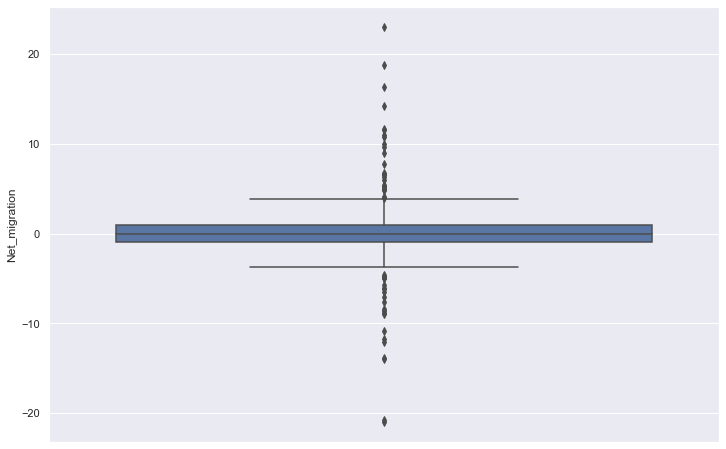

In [29]:
# observando os outliers
sns.boxplot(countries.Net_migration, orient='vertical')

In [30]:
# inspirado no notebook do Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)
quant1 = countries['Net_migration'].quantile(0.25)
quant3 = countries['Net_migration'].quantile(0.75)
iqr = quant3 - quant1

non_outlier_interval_iqr = [quant1 - 1.5 * iqr, quant3 + 1.5 * iqr]

print(f"Faixa considerada \"normal\": {non_outlier_interval_iqr}")

Faixa considerada "normal": [-3.8149999999999995, 3.885]


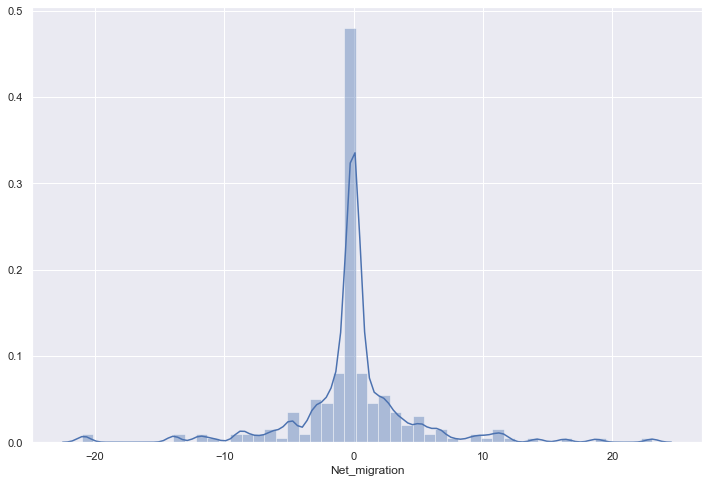

In [31]:
sns.distplot(countries.Net_migration.fillna(0));

In [32]:
outliers_iqr = countries.Net_migration[(countries.Net_migration < non_outlier_interval_iqr[0]) | (countries.Net_migration > non_outlier_interval_iqr[1])]

outliers_abaixo = countries.Net_migration[(countries.Net_migration < non_outlier_interval_iqr[0]) ]
outliers_acima = countries.Net_migration[(countries.Net_migration > non_outlier_interval_iqr[1]) ]

print(len(outliers_abaixo))

print(len(outliers_acima))

outliers_iqr

24
26


0      23.06
1      -4.93
3     -20.71
4       6.60
6      10.76
7      -6.15
9      -6.47
11      3.98
13     -4.90
28     10.01
30     -4.58
36      5.96
37    -12.07
38     18.75
56    -13.87
59     -8.58
70      6.27
75     -4.70
80     -8.37
81    -13.92
91      5.24
98      4.99
99      5.36
102    -4.92
105     6.59
111    14.18
119     4.85
121     8.97
122     4.86
130    -6.04
134     6.78
135    -4.87
136   -20.99
138     7.75
149     4.05
153     9.61
166    16.29
172    -7.11
174    -4.86
175    -7.64
176   -11.70
177    10.98
182    -5.69
184    11.53
188     5.37
193    -8.81
196     4.05
204   -10.83
208    11.68
220    -8.94
Name: Net_migration, dtype: float64

In [33]:
type((len(outliers_abaixo), len(outliers_acima), False))

tuple

In [34]:
def q5():
    # Retorne aqui o resultado da questão 4.
    return (len(outliers_abaixo), len(outliers_acima), False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [37]:
# so be it
categories = ["sci.electronics", "comp.graphics", "rec.motorcycles"]
newsgroups = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

Este [tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) sobre o tema é bem didático.

In [38]:
cv = CountVectorizer()
newsgroups_counts = cv.fit_transform(newsgroups.data)

#todas as palavras do _corpus_
newsgroups_counts.shape

(1773, 27335)

In [39]:
# encontrando o índice da que nos interessa
cv.vocabulary_.get(u'phone')

19211

In [40]:
# usando o método certo para ter acesso numa matriz esparsa
phone_column = newsgroups_counts.getcol(cv.vocabulary_.get(u'phone'))

In [42]:
type(phone_column.sum())

numpy.int64

In [43]:
def q6():
    # Retorne aqui o resultado da questão 4.
    return int(phone_column.sum())

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [44]:
# Apenas transformando a matriz de frequencia
tfidf_transformer = TfidfTransformer()

newsgroups_counts_tfidf = tfidf_transformer.fit_transform(newsgroups_counts)
newsgroups_counts_tfidf.shape

(1773, 27335)

In [45]:
# podemos usar o mesmo indice
phone_tfidf = newsgroups_counts_tfidf.getcol(cv.vocabulary_.get(u'phone'))

In [46]:
type(phone_tfidf.sum().round(3))

numpy.float64

In [48]:
def q7():
    # Retorne aqui o resultado da questão 4.
    return float(phone_tfidf.sum().round(3))

## Ufa!!!